Code extracted from nems/scripts/demo_script_2p.py

In [1]:
%matplotlib inline
import os
import logging
import pandas as pd
import pickle
import sys
import numpy as np

from nems.gui.recording_browser import browse_recording, browse_context
import nems
import nems.initializers
import nems.priors
import nems.preprocessing as preproc
import nems.plots.api as nplt
import nems.modelspec as ms
import nems.xforms as xforms
import nems.utils
import nems.uri
import nems.recording as recording
from nems.signal import RasterizedSignal
from nems.fitters.api import scipy_minimize
import nems.db as nd

log = logging.getLogger(__name__)


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2018-12-05 131150.log
/auto/users/svd/python/nems_test/nems/gui/recording_browser.py:32: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/site-packages/traitlets/config/application.py", l

here's the loading/parameter setting part

In [2]:
# ----------------------------------------------------------------------------
# LOAD AND FORMAT RECORDING DATA

# data file and results locations
# defined in nems/nems/configs/settings.py, which will override
# defaults in nems/nems/configs/defaults.py
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
recordings_dir = nems.get_setting('NEMS_RECORDINGS_DIR')

# 2p data from Polley Lab at EPL
respfile = os.path.join(recordings_dir, 'data_nems_2p/neurons.csv')
stimfile = os.path.join(recordings_dir, 'data_nems_2p/stim_spectrogram.csv')
exptid = "POL001"
cellid = "POL001-080"
batch = 1  # define the group of data this belong to (eg, 1: A1, 2: AAF, etc)
load_command='nems.demo.loaders.load_polley_data'

# MODEL SPEC
# modelspecname = 'dlog_wcg18x1_stp1_fir1x15_lvl1_dexp1'
modelspecname = 'wc.9x1.g-fir.1x15-lvl.1'
modelspecname = 'dlog-wc.9x2.g-fir.2x15-lvl.1'
meta = {'cellid': cellid, 'batch': batch, 'modelname': modelspecname}


In [ ]:
from nems.demo.loaders import load_polley_data
r = load_polley_data(load_command=load_command,
                respfile=respfile,
                stimfile=stimfile,
                exptid=exptid,
                cellid=cellid)

In [25]:
print(r.keys())
print(r['stim'].shape)

dict_keys(['fs', 'resp', 'stim', 'stim_labels', 'resp_labels'])
(9, 85051)


In [3]:
xfspec = []
xfspec.append(['nems.xforms.load_recording_wrapper',
               {'load_command': load_command,
                'respfile': respfile,
                'stimfile': stimfile,
                'exptid': exptid,
                'cellid': cellid}])

# reserve 10% of the data for validation
xfspec.append(['nems.xforms.split_at_time', {'valfrac': 0.1}])

xfspec.append(['nems.xforms.init_from_keywords',
               {'keywordstring': modelspecname, 'meta': meta}])

xfspec.append(['nems.xforms.fit_basic_init', {}])
xfspec.append(['nems.xforms.fit_basic', {}])
xfspec.append(['nems.xforms.predict',    {}])
# xfspec.append(['nems.xforms.add_summary_statistics',    {}])
xfspec.append(['nems.analysis.api.standard_correlation', {},
               ['est', 'val', 'modelspec', 'rec'], ['modelspec']])
xfspec.append(['nems.xforms.plot_summary',    {}])


In [4]:
xfspec

[['nems.xforms.load_recording_wrapper',
  {'load_command': 'nems.demo.loaders.load_polley_data',
   'respfile': '/auto/users/svd/projects/nems_test/recordings/data_nems_2p/neurons.csv',
   'stimfile': '/auto/users/svd/projects/nems_test/recordings/data_nems_2p/stim_spectrogram.csv',
   'exptid': 'POL001',
   'cellid': 'POL001-080'}],
 ['nems.xforms.split_at_time', {'valfrac': 0.1}],
 ['nems.xforms.init_from_keywords',
  {'keywordstring': 'dlog-wc.9x2.g-fir.2x15-lvl.1',
   'meta': {'cellid': 'POL001-080',
    'batch': 1,
    'modelname': 'dlog-wc.9x2.g-fir.2x15-lvl.1'}}],
 ['nems.xforms.fit_basic_init', {}],
 ['nems.xforms.fit_basic', {}],
 ['nems.xforms.predict', {}],
 ['nems.analysis.api.standard_correlation',
  {},
  ['est', 'val', 'modelspec', 'rec'],
  ['modelspec']],
 ['nems.xforms.plot_summary', {}]]

[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file /auto/users/svd/projects/nems_test/recordings/POL001_6d39a8c6f579f8762d24e0e88955bb216c6b5e0f.tgz
[nems.xforms INFO] match found, extracting channel from rec
[nems.xforms INFO] Evaluating: nems.xforms.split_at_time
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: dlog
[nems.initializers INFO] kw: wc.9x2.g
[nems.initializers INFO] kw: fir.2x15
[nems.initializers INFO] kw: lvl.1
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.initializers INFO] target_module: levelshift found at modelspec[3].
[nems.fitters.fitter INFO] Starting sigma: [0.0, 0.41666666666666663, 0.5833333333333333, 0.3191538243211462, 0.3191538243211462, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/s

[nems.xforms INFO] Evaluating: nems.xforms.predict
[nems.xforms INFO] Evaluating: nems.analysis.api.standard_correlation
[nems.xforms INFO] Evaluating: nems.xforms.plot_summary
[nems.plots.quickplot INFO] Running quickplot
[nems.plots.quickplot INFO] quickplot for SIGNAL epochs


CHANS: 
['4.0', '5.7', '8.0', '11.3', '16.0', '22.6', '32.0', '45.3', '64.0']


[nems.xforms INFO] Done (re-)evaluating xforms.


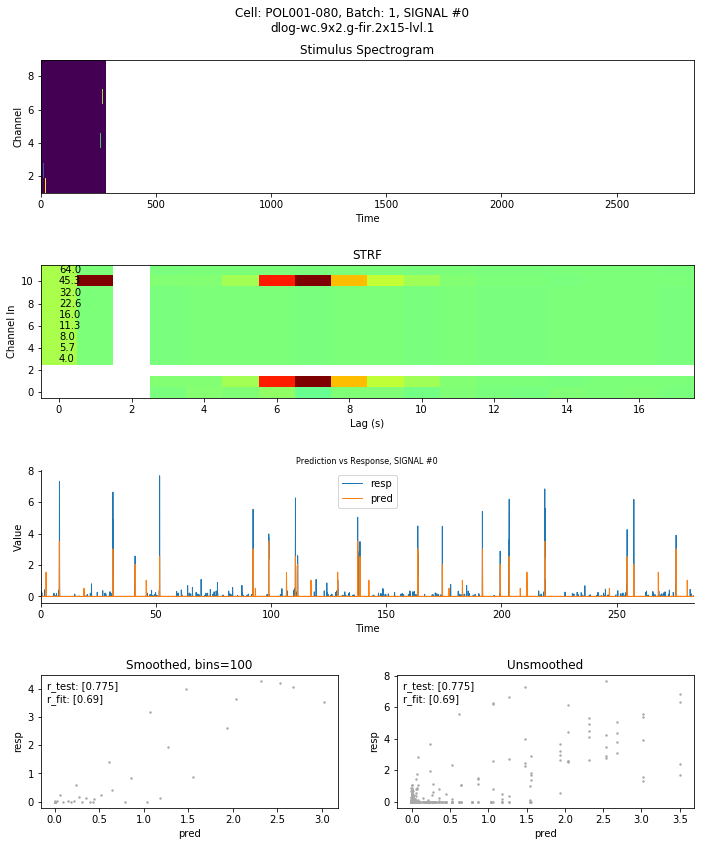

In [5]:
# actually do the fit
ctx, log_xf = xforms.evaluate(xfspec)

# shorthand for:
# ctx = {}
# for xfa in xfspec:
#     ctx = xforms.evaluate_step(xfa, ctx)


In [7]:
ctx['val'].signals

{'resp': <nems.signal.RasterizedSignal at 0x7fbd50e3a588>,
 'stim': <nems.signal.RasterizedSignal at 0x7fbd50e3a2e8>,
 'pred': <nems.signal.RasterizedSignal at 0x7fbd50e3da58>}

/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


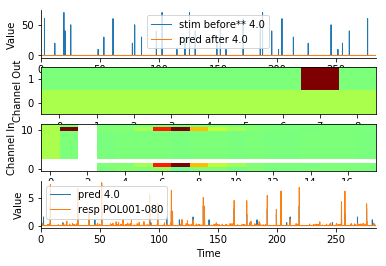

In [10]:
# testing new plotting system
modelspec = ctx['modelspec']
modelspec[0]['plot_fn_idx']=2
fig=modelspec.quickplot(ctx['val'])
fig.show()


In [11]:
modelspec.meta()

{'cellid': 'POL001-080',
 'batch': 1,
 'modelname': 'dlog-wc.9x2.g-fir.2x15-lvl.1',
 'fitter': 'fit_basic',
 'fit_time': 48.752553939819336,
 'n_parms': 36,
 'r_test': array([0.77461431]),
 'se_test': array([0.03118736]),
 'r_floor': array([0.0528002]),
 'mse_test': array([0.66229799]),
 'se_mse_test': array([0.02924614]),
 'll_test': 0.45891389881767575,
 'r_fit': array([0.69024159]),
 'se_fit': array([0.01414273]),
 'r_ceiling': 0,
 'mse_fit': array([0.7235967]),
 'se_mse_fit': array([0.01347019]),
 'll_fit': 0.5222135091939346}

In [12]:
# ----------------------------------------------------------------------------
# SAVE YOUR RESULTS

# save results to file
destination = os.path.join(results_dir, str(batch), xforms.get_meta(ctx)['cellid'],
                           ms.get_modelspec_longname(ctx['modelspec']))
log.info('Saving modelspec(s) to {0} ...'.format(destination))
xforms.save_analysis(destination,
                     recording=ctx['rec'],
                     modelspec=ctx['modelspec'],
                     xfspec=xfspec,
                     figures=ctx['figures'],
                     log=log_xf)

# save summary of results to a database
log.info('Saving metadata to db  ...')
modelspec = ctx['modelspec']
modelspec.meta()['modelpath'] = destination
modelspec.meta()['figurefile'] = destination + 'figure.0000.png'
nd.update_results_table(modelspec)
    

[__main__ INFO] Saving modelspec(s) to /auto/users/svd/projects/nems_test/results/1/POL001-080/unknown_recording.dlog_wc.9x2.g_fir.2x15_lvl.1.fit_basic.2018-12-05T211722 ...
[__main__ INFO] Saving metadata to db  ...


3

In [2]:
# reload using:
# repeated from above
import nems.db as nd
import nems.xforms as xforms

# pick your cell/batch/model
cellid = "POL001-080"
batch = 1  # define the group of data this belong to (eg, 1: A1, 2: AAF, etc)
modelspecname = 'wc.9x1.g-fir.1x15-lvl.1'

# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid], modelnames=[modelspecname])
d.loc[0]
filepath = d['modelpath'][0] + '/'

# load and display results
xfspec, ctx = xforms.load_analysis(filepath, eval_model=True)


[nems.xforms INFO] Loading modelspec from /auto/users/svd/projects/nems_test/results/1/POL001-080/unknown_recording.wc.9x1.g_fir.1x15_lvl.1.fit_basic.2018-12-05T210456/...
[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file /auto/users/svd/projects/nems_test/recordings/POL001_6d39a8c6f579f8762d24e0e88955bb216c6b5e0f.tgz
[nems.xforms INFO] match found, extracting channel from rec
[nems.xforms INFO] Evaluating: nems.xforms.split_at_time
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic
[nems.xforms INFO] Evaluating: nems.xforms.predict
/home/svd/bin/miniconda3/envs/nems_test/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array

In [20]:
import nems.db as nd
import nems.xforms as xforms

# pick your cell/batch/model
cellid = "POL001-080"
batch = 1  # define the group of data this belong to (eg, 1: A1, 2: AAF, etc)
modelspecname = 'wc.9x1.g-fir.1x15-lvl.1'

# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid])
d[['modelname','r_test','figurefile']]

,modelname,r_test,figurefile
0,dlog-wc.9x2.g-fir.2x15-lvl.1,0.774614,/auto/users/svd/projects/nems_test/results/1/P...
1,wc.9x1.g-fir.1x15-lvl.1,0.775670,/auto/users/svd/projects/nems_test/results/1/P...


In [6]:
modelspec=ctx['modelspec']
modelspec.meta()

{'cellid': 'POL001-080',
 'batch': 1,
 'modelname': 'wc.9x1.g-fir.1x15-lvl.1',
 'fitter': 'fit_basic',
 'fit_time': 0.44434118270874023,
 'n_parms': 18,
 'r_test': array([0.77566994]),
 'se_test': array([0.03108066]),
 'r_floor': array([0.04457513]),
 'mse_test': array([0.66091728]),
 'se_mse_test': array([0.02945958]),
 'll_test': 0.4482404081957795,
 'r_fit': array([0.6913715]),
 'se_fit': array([0.01415284]),
 'r_ceiling': 0,
 'mse_fit': array([0.72251715]),
 'se_mse_fit': array([0.01355246]),
 'll_fit': 0.48364801153937,
 'xfspec': '/auto/users/svd/projects/nems_test/results/1/POL001-080/unknown_recording.wc.9x1.g_fir.1x15_lvl.1.fit_basic.2018-12-05T210456/xfspec.json'}